# Interconnect: Telecommunication Provider Company

Interconnect, a telecommunications operator, wants to forecast their customer churn rate. If it is known that a customer plans to leave, they will be offered promotional codes and special package options. Interconnect's marketing team has collected some customer personal data, including information about the selected data packages and their contracts.

# Interconnect Services
Interconnect provides two main services:

Home phone network: Phones can be connected to multiple lines simultaneously.
Internet: The internet connection can be set up through telephone lines (DSL, digital subscriber line) or via fiber optic cable.
Some other services offered by Interconnect include:

Internet security: antivirus software (DeviceProtection) and blocking of malicious websites (OnlineSecurity)
Dedicated technical support (TechSupport)
Cloud storage for file and data backups (OnlineBackup)
TV streaming (StreamingTV) and movie directory (StreamingMovies)
Customers can choose to make monthly payments or sign contracts for 1 or 2-year subscriptions. They can use various payment methods and receive electronic bills after transactions are made.

# Data Description

The available data consists of several files obtained from different sources:

- contract.csv - contract information
- personal.csv - customer personal data
- internet.csv - information about internet services
- phone.csv - information about phone services

In each file, you can find a customerID column with a unique code assigned to each customer.

The contract information is valid as of February 1, 2020.

# Goals
Train a model that can predict when Interconnect client's are going to leave.

**Steps to be taken:**
1. Examining and studying the data from each table:
  - Conducting initial exploratory analysis on the data.
  - Addressing any data issues that are identified.
  - Visualizing the data for better understanding.

2. Preparing the data for model training:
  - Merging the data and do some data engineering.
  - Labeling the data considering the prediction objective.
  - Scaling the data if necessary to address feature scale differences.

3. Training and testing the model:
  - Splitting the data into a training set and a validation set with a 75:25 ratio.
  - Training the model using the training set and making predictions for the validation set.
  - Saving the predictions and the correct answers for the validation set.
  - Displaying the predicted churn dates and the model's AUC-ROC and accuracy values.
  - Analyzing the obtained results to evaluate the model's performance.

# Installing Library

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import time


from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## Load Data

In [ ]:
contract = pd.read_csv('/content/drive/MyDrive/FILE PRACTICUM/Sprint 17/contract.csv')
clients = pd.read_csv('/content/drive/MyDrive/FILE PRACTICUM/Sprint 17/personal.csv')
internet = pd.read_csv('/content/drive/MyDrive/FILE PRACTICUM/Sprint 17/internet.csv')
phone = pd.read_csv('/content/drive/MyDrive/FILE PRACTICUM/Sprint 17/phone.csv')

## Initial Data Exploration

### Contract Data Preprocessing

In [ ]:
display(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [ ]:
contract.rename(columns={"customerID": "customer_id", "BeginDate": "begin_date", "EndDate": "end_date",\
                         "Type":"type", "PaperlessBilling":"paperless_billing", "PaymentMethod":"payment_method"\
                        ,"MonthlyCharges":"monthly_charges","TotalCharges":"total_charges"},\
               inplace=True)

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
#Checking for NaNs in contract.
print('contract NaNs:', contract.isna().sum().sum())
#Checking for duplicates in contract.
print('contract duplicates:', contract.duplicated().sum())

contract NaNs: 0
contract duplicates: 0


In [ ]:
# Checking unique values
print('Unique values in "type" column:', contract.type.unique())
print()
print('Unique values in "paperless_billing" column:', contract.paperless_billing.unique())
print()
print('Unique values in "payment_method" column:', contract.payment_method.unique())

Unique values in "type" column: ['Month-to-month' 'One year' 'Two year']

Unique values in "paperless_billing" column: ['Yes' 'No']

Unique values in "payment_method" column: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [ ]:
# Modify begin_date type.
contract.begin_date = pd.to_datetime(contract.begin_date)

In [ ]:
# Transforming all empty values in total_charges column (" ") to zeros.
contract.loc[contract.total_charges == " " , 'total_charges'] = 0.00

In [ ]:
# Changing total_charges type to floating points.
contract.total_charges = pd.to_numeric(contract.total_charges, downcast='float')
contract.monthly_charges = contract.monthly_charges.astype('float64')
contract.total_charges = contract.total_charges.astype('float64').round(2)

In [ ]:
# Further information on contract df
print('The describe method of the dataset contract.csv is:')
print()
print(contract.describe())

The describe method of the dataset contract.csv is:

       monthly_charges  total_charges
count      7043.000000    7043.000000
mean         64.761692    2279.734304
std          30.090047    2266.794470
min          18.250000       0.000000
25%          35.500000     398.550000
50%          70.350000    1394.550000
75%          89.850000    3786.600000
max         118.750000    8684.800000


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


In [ ]:
#Analyzing paperless_billing column.
print(contract.paperless_billing.value_counts())
print()
print(contract.paperless_billing.value_counts(normalize=True))

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64


In [ ]:
#Analyzing type column.
print(contract.type.value_counts())
print()
print(contract.type.value_counts(normalize=True))

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64


In [ ]:
#Analyzing payment_method column.
print(contract.payment_method.value_counts())
print()
print(contract.payment_method.value_counts(normalize=True))

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64


### Clients Data Preprocessing

In [ ]:
display(clients)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [ ]:
clients.rename(columns={"customerID": "customer_id", "SeniorCitizen": "senior_citizen",\
                         "Partner":"partner", "Dependents":"dependents"},\
               inplace=True)

clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
# Checking for NaNs in clients dataframe
print('Clients NaNs:', contract.isna().sum().sum())
# Checking for duplicates in clients dataframe
print('Clients duplicates:', contract.duplicated().sum())

Clients NaNs: 0
Clients duplicates: 0


In [ ]:
#Analyzing gender column.
print(clients.gender.value_counts())
print()
print(clients.gender.value_counts(normalize=True))

Male      3555
Female    3488
Name: gender, dtype: int64

Male      0.504756
Female    0.495244
Name: gender, dtype: float64


In [ ]:
#Analyzing senior_citizen column.
print(clients.senior_citizen.value_counts())
print()
print(clients.senior_citizen.value_counts(normalize=True))

0    5901
1    1142
Name: senior_citizen, dtype: int64

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64


In [ ]:
#Analyzing partner column.
print(clients.partner.value_counts())
print()
print(clients.partner.value_counts(normalize=True))

No     3641
Yes    3402
Name: partner, dtype: int64

No     0.516967
Yes    0.483033
Name: partner, dtype: float64


In [ ]:
#Analyzing dependents column.
print(clients.dependents.value_counts())
print()
print(clients.dependents.value_counts(normalize=True))

No     4933
Yes    2110
Name: dependents, dtype: int64

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64


### Internet Data Preprocessing

In [ ]:
display(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.rename(columns={"customerID": "customer_id", "InternetService":"internet_service","OnlineSecurity":"online_security",\
                        "OnlineBackup":"online_backup","DeviceProtection":"device_protection","TechSupport":"tech_support",\
                        "StreamingTV":"streaming_tv","StreamingMovies":"streaming_movies"}, inplace=True)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
#Checking for NaNs in internet.
print('internet NaNs:', internet.isna().sum().sum())
#Checking for duplicates in internet.
print('internet duplicates:', internet.duplicated().sum())

internet NaNs: 0
internet duplicates: 0


In [ ]:
#Analyzing internet_service column.
print(internet.internet_service.value_counts())
print()
print(internet.internet_service.value_counts(normalize=True))

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64


In [ ]:
#Analyzing online_security column.
print(internet.online_security.value_counts())
print()
print(internet.online_security.value_counts(normalize=True))

No     3498
Yes    2019
Name: online_security, dtype: int64

No     0.63404
Yes    0.36596
Name: online_security, dtype: float64


In [ ]:
#Analyzing online_backup column.
print(internet.online_backup.value_counts())
print()
print(internet.online_backup.value_counts(normalize=True))

No     3088
Yes    2429
Name: online_backup, dtype: int64

No     0.559724
Yes    0.440276
Name: online_backup, dtype: float64


In [ ]:
#Analyzing device_protection column.
print(internet.device_protection.value_counts())
print()
print(internet.device_protection.value_counts(normalize=True))

No     3095
Yes    2422
Name: device_protection, dtype: int64

No     0.560993
Yes    0.439007
Name: device_protection, dtype: float64


In [ ]:
#Analyzing tech_support column.
print(internet.tech_support.value_counts())
print()
print(internet.tech_support.value_counts(normalize=True))

No     3473
Yes    2044
Name: tech_support, dtype: int64

No     0.629509
Yes    0.370491
Name: tech_support, dtype: float64


In [ ]:
#Analyzing streaming_tv column.
print(internet.streaming_tv.value_counts())
print()
print(internet.streaming_tv.value_counts(normalize=True))

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

No     0.509335
Yes    0.490665
Name: streaming_tv, dtype: float64


In [ ]:
#Analyzing streaming_movies column.
print(internet.streaming_movies.value_counts())
print()
print(internet.streaming_movies.value_counts(normalize=True))

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

No     0.504803
Yes    0.495197
Name: streaming_movies, dtype: float64


### Phone Data Preprocessing

In [ ]:
display(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [ ]:
phone.rename(columns={"customerID": "customer_id", "MultipleLines":"multiple_lines"}, inplace=True)

phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
#Checking for NaNs in phone.
print('phone NaNs:', phone.isna().sum().sum())
#Checking for duplicates in internet.
print('phone duplicates:', phone.duplicated().sum())

phone NaNs: 0
phone duplicates: 0


In [ ]:
#Analyzing multiple_lines column.
print(phone.multiple_lines.value_counts())
print()
print(phone.multiple_lines.value_counts(normalize=True))

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64


### Target Preprocessing

In [ ]:
#Target analysis.
print(contract.end_date.value_counts())
print()
print(contract.end_date.value_counts(normalize=True))

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: end_date, dtype: float64


In [ ]:
contract['target'] = np.where((contract['end_date'] != 'No'), 'Yes', contract['end_date'])

In [ ]:
contract.target.value_counts()

No     5174
Yes    1869
Name: target, dtype: int64

### Creating New Features

In [ ]:
#Assigning 2020-02-01 00:00:00 where there's no in end_date column.
contract['end_date'] = np.where((contract['end_date'] == 'No'), '2020-02-01 00:00:00', contract['end_date'])

In [ ]:
#Changing end_date type.
contract.end_date = pd.to_datetime(contract.end_date)
print(contract.end_date.value_counts())

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: end_date, dtype: int64


In [ ]:
contract['days_with_company'] = contract.end_date - contract.begin_date

In [ ]:
#obtaining integers from time_delta Series.
contract['days_with_company'] = (contract['days_with_company']).dt.days

## Data Visualization

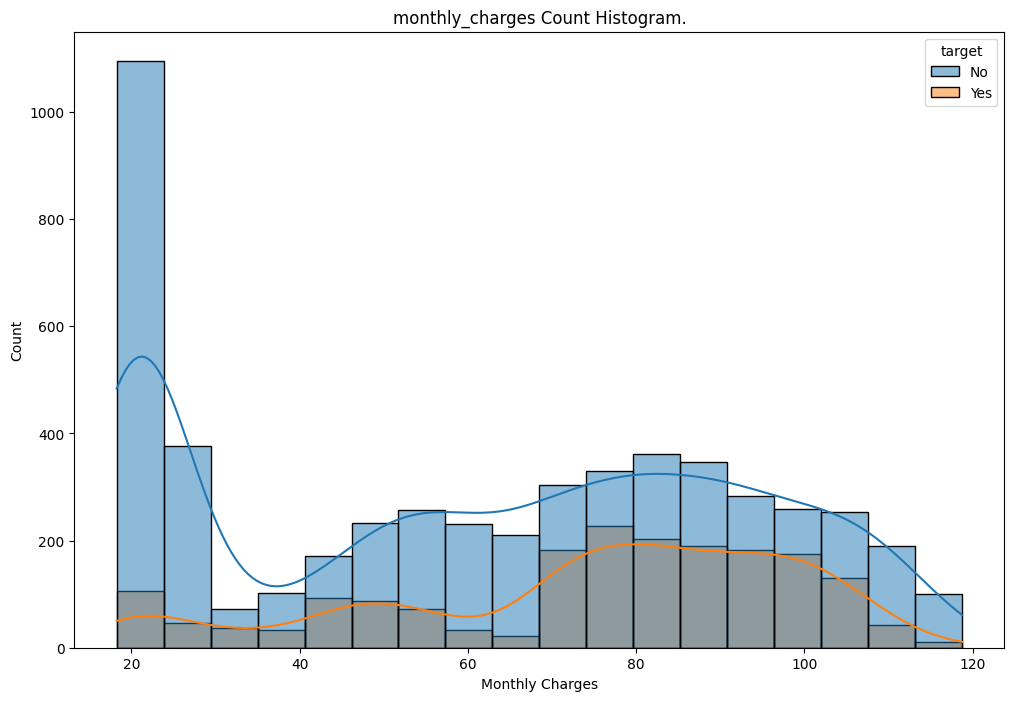

In [ ]:
# Monthly Charges visualization.
plt.figure(figsize=(12,8))
sns.histplot(x='monthly_charges', data=contract, kde=True, hue='target')
plt.xlabel('Monthly Charges')
plt.title('monthly_charges Count Histogram.')
plt.show()

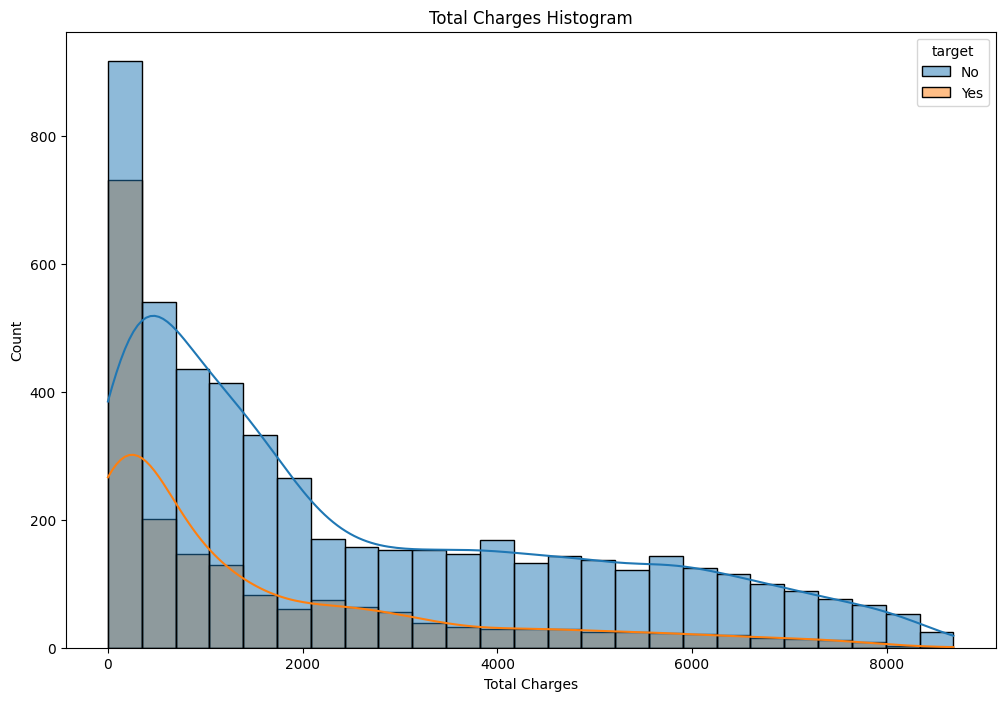

In [ ]:
# Total Charges Visualization
plt.figure(figsize=(12,8))
sns.histplot(x='total_charges', data=contract, kde=True, hue='target')
plt.xlabel('Total Charges')
plt.title('Total Charges Histogram')
plt.show()

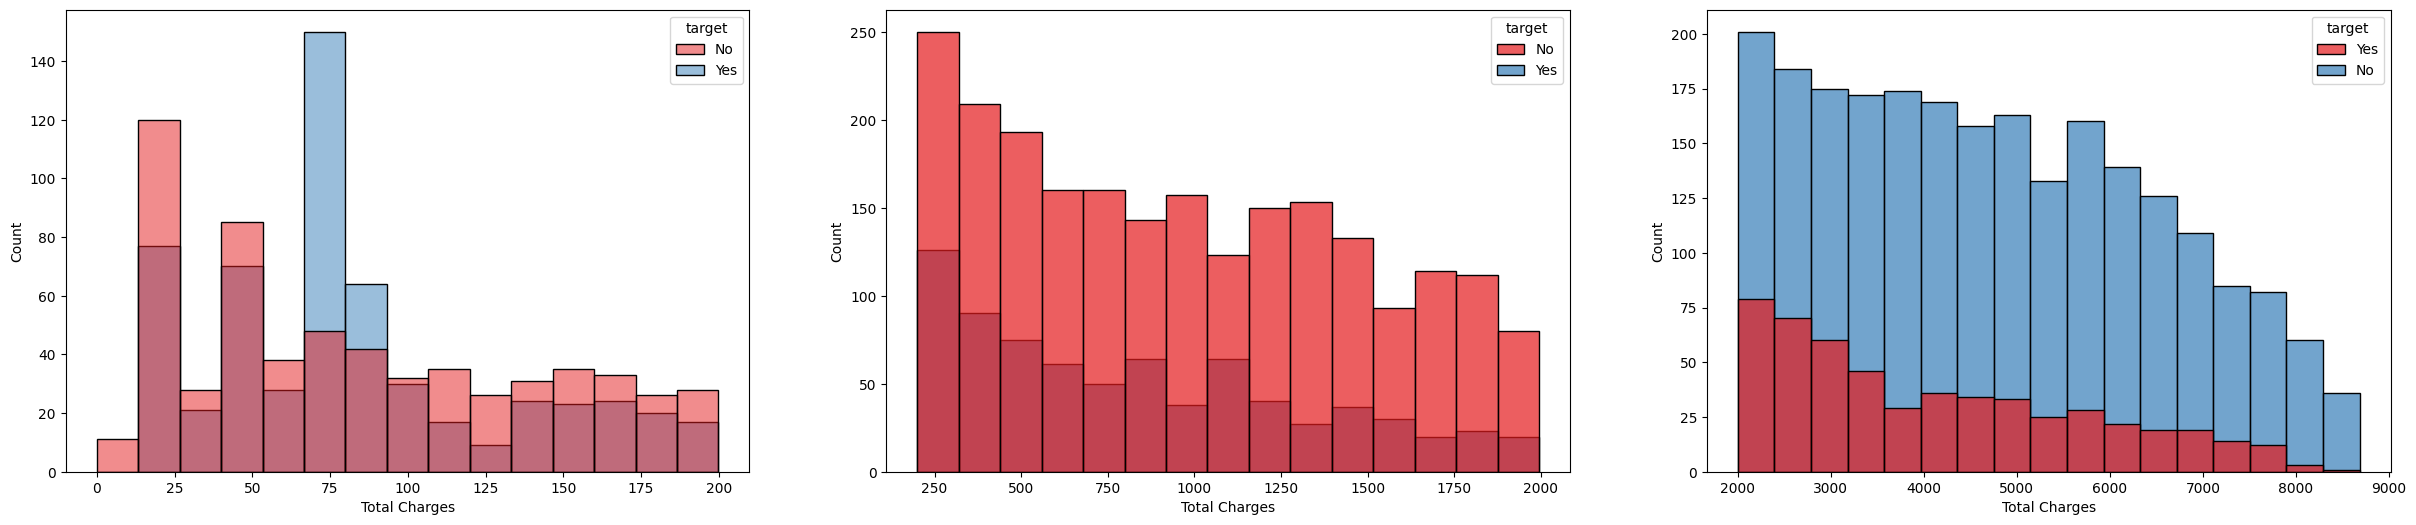

In [ ]:
#Dividing the total_charges column in total_charges < 200, btw 200 and 2000 and > 2000 to get a better visualization of graphs.
total_charges_200 = contract.query('total_charges < 200')
total_charges_2000 = contract.query('total_charges > 200 and total_charges < 2000')
total_charges_over = contract.query('total_charges > 2000')

plt.figure(figsize=(30,6)) # specifying figure size
ax1 = plt.subplot(1,3,1)
sns.histplot(data=total_charges_200, x='total_charges', ax=ax1, hue='target', palette='Set1')
plt.xlabel('Total Charges')
ax2 = plt.subplot(1,3,2)
sns.histplot(data=total_charges_2000, x='total_charges', ax=ax2, hue='target', alpha=0.7, palette='Set1')
plt.xlabel('Total Charges')
ax3 = plt.subplot(1,3,3)
sns.histplot(data=total_charges_over, x='total_charges', ax=ax3, hue='target', alpha=0.7, palette='Set1')
plt.xlabel('Total Charges')
plt.show()

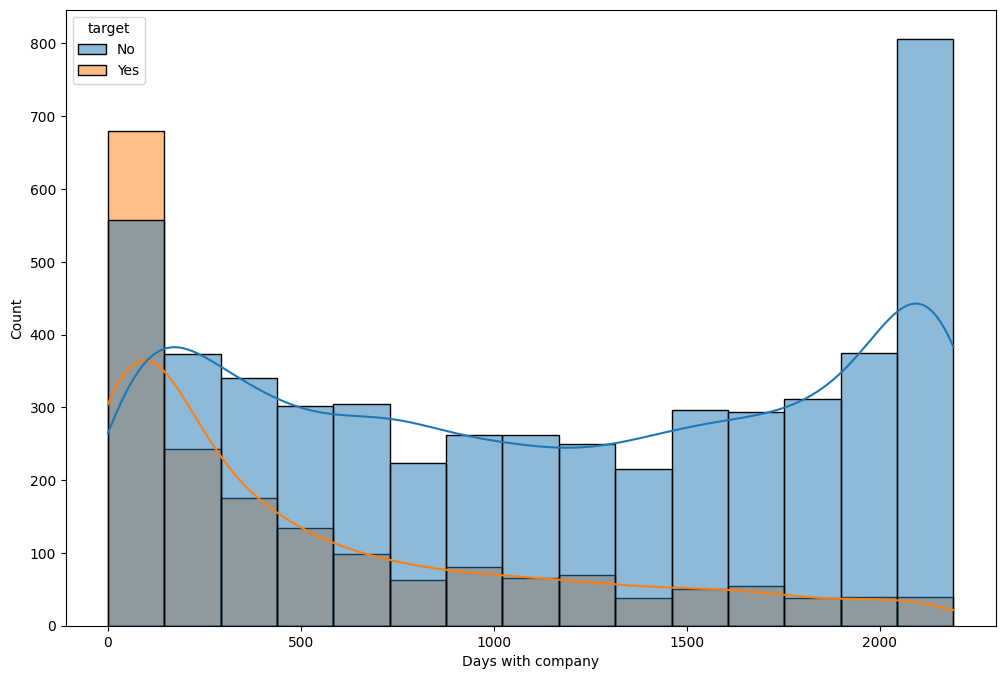

In [ ]:
#Visualizing histograms of days_with_company column.
plt.figure(figsize=(12,8))
sns.histplot(x='days_with_company', data=contract, kde=True, hue='target')
plt.xlabel('Days with company')
plt.show()


Based on the above visualization, it can be observed that clients who churn tend to have a lower tenure.

## Brief Summary

Here are the conclusions that can be drawn from the initial exploratory data:
1. The percentage of male and female clients is equal, with the majority of clients (84%) being young. There is an equal distribution between married and unmarried clients, with 70% of them not having dependents.

2. Regarding internet features, there are 7 available features with the following distribution:
	- Only 56% of clients use fiber optic connection.
	- Only 36% of clients use online security feature.
	- Only 43% of clients use device protection feature.
	- Only 44% of clients use online backup feature.
	- Only 37% of clients use specialized technical support.
	- Only 50% of clients use streaming TV and movie services.

3. The number of clients using multiple lines for their phones is only 46%.

4. Information from the contract table:
	- The payment types are divided into monthly (55%), one year (21%), and two years (24%).
	- 59% of clients opt for paperless billing.
	- The commonly used payment methods are E-Check (33.5%), Mailed Check (22.8%), Bank Transfer (21.9%), and Credit Card (21.6%).
	- The average monthly bill is $64.

	- The average total bill is $2280.
	- 73% of clients are still under contract with the network provider.

# Data Preparation for Model Training

In [ ]:
df = contract.merge(internet, on = 'customer_id', how='outer')
df = df.merge(phone, on = 'customer_id', how='outer')
df = df.merge(clients, on='customer_id', how='outer')

In [ ]:
display(df)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,days_with_company,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,...,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,...,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,...,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,...,No,No,No,No,No,No,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,No,730,...,No,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,No,2191,...,Yes,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,No,337,...,No,No,No,No,No,NaN,Female,0,Yes,Yes
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,123,...,No,No,No,No,No,Yes,Male,1,Yes,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   object        
 9   days_with_company  7043 non-null   int64         
 10  internet_service   5517 non-null   object        
 11  online_security    5517 non-null   object        
 12  online_backup      5517 non-null   object        
 13  device_protection  5517 non-null   object        
 14  tech_sup

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,days_with_company,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,...,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,...,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,...,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,...,No,No,No,No,No,No,Female,0,No,No


In [ ]:
#Creating has_phone feature.
df['has_phone'] = np.where((df['multiple_lines'] == 'No'), 1, np.nan)
df.loc[df['multiple_lines'] == 'Yes', 'has_phone'] = 1
df.has_phone = df['has_phone'].replace(np.nan, 0)
df.has_phone = df.has_phone.astype('int16')
print(df['has_phone'].value_counts(dropna=False))

1    6361
0     682
Name: has_phone, dtype: int64


In [ ]:
#Creating has_internet feature.
df['has_internet'] = np.where((df['device_protection'] == 'No'), 1, np.nan)
df.loc[df['device_protection'] == 'Yes', 'has_internet'] = 1
df.has_internet = df['has_internet'].replace(np.nan, 0)
df.has_internet = df.has_internet.astype('int16')
print(df['has_internet'].value_counts(dropna=False))

1    5517
0    1526
Name: has_internet, dtype: int64


In [ ]:
columns_to_fill = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for column in columns_to_fill:
    df[column].fillna("Other", inplace=True)

## Label Encoding

In [ ]:
#Encoding the dataset
"""original = df.copy()
df = df.drop(['customer_id','begin_date','end_date','monthly_charges','total_charges','days_with_company'], axis=1)
df = df.astype(str).apply(LabelEncoder().fit_transform)"""

"original = df.copy()\ndf = df.drop(['customer_id','begin_date','end_date','monthly_charges','total_charges','days_with_company'], axis=1)\ndf = df.astype(str).apply(LabelEncoder().fit_transform)"

In [ ]:
#Re-adding dropped columns.
"""df['begin_date'] = original['begin_date']
df['end_date'] = original['end_date']
df['monthly_charges'] = original['monthly_charges']
df['total_charges'] = original['total_charges']
df['days_with_company'] = original['days_with_company']"""

"df['begin_date'] = original['begin_date']\ndf['end_date'] = original['end_date']\ndf['monthly_charges'] = original['monthly_charges']\ndf['total_charges'] = original['total_charges']\ndf['days_with_company'] = original['days_with_company']"

In [ ]:
#Examinate the interested target column.
"""print('The number of non-exited customers is:', df.target.loc[df.target == 0].count())
print()
print('The number of exited customers is:', df.target.loc[df.target == 1].count())
print()
print('The percentage of non-exited customers is:', (len(df.target.loc[df.target == 0])/len(df.target)*100),'%')
print()
print('The percentage of exited customers is:', (len(df.target.loc[df.target == 1])/len(df.target)*100),'%')"""

"print('The number of non-exited customers is:', df.target.loc[df.target == 0].count())\nprint()\nprint('The number of exited customers is:', df.target.loc[df.target == 1].count())\nprint()\nprint('The percentage of non-exited customers is:', (len(df.target.loc[df.target == 0])/len(df.target)*100),'%')\nprint()\nprint('The percentage of exited customers is:', (len(df.target.loc[df.target == 1])/len(df.target)*100),'%')"

In [ ]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'target',
       'days_with_company', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'gender', 'senior_citizen',
       'partner', 'dependents', 'has_phone', 'has_internet'],
      dtype='object')

In [ ]:
df = pd.get_dummies(data=df, columns=['type', 'paperless_billing',
       'payment_method', 'gender','senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'])

In [ ]:
df['month_begin_date'] = df['begin_date'].dt.month
df['year_begin_date'] = df['begin_date'].dt.year
df.drop(['begin_date'], axis=1, inplace=True)

In [ ]:
df['end_date'].replace({'No':0, 'Yes':1}, inplace=True)
df['target'].replace({'No':0, 'Yes':1}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   customer_id                               7043 non-null   object        
 1   end_date                                  7043 non-null   datetime64[ns]
 2   monthly_charges                           7043 non-null   float64       
 3   total_charges                             7043 non-null   float64       
 4   target                                    7043 non-null   int64         
 5   days_with_company                         7043 non-null   int64         
 6   has_phone                                 7043 non-null   int16         
 7   has_internet                              7043 non-null   int16         
 8   type_Month-to-month                       7043 non-null   uint8         
 9   type_One year                 

## Split Data

In [ ]:
#Assigning features and target for the model construction.
features = df.drop(['customer_id', 'end_date', 'target'], axis=1)
target = df['target']

#Train test split.
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                           test_size=0.25,
                                                                            random_state=12345)

In [ ]:
df.target.value_counts()

0    5174
1    1869
Name: target, dtype: int64

In [ ]:
#Balancing dataset. Upsampling to handle the imbalance.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + ([features_ones] * repeat))
    target_upsampled = pd.concat([target_zeros] + ([target_ones] * repeat))

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=0
    )

    return features_upsampled, target_upsampled

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

features_upsampled.shape, target_upsampled.shape

((8072, 47), (8072,))

In [ ]:
#Examinate the interested target column.
print('The number of non-exited customers is:', target_upsampled.loc[target_upsampled == 0].count())
print()
print('The number of exited customers is:', target_upsampled.loc[target_upsampled == 1].count())
print()
print('The percentage of non-exited customers is:', (len(target_upsampled.loc[target_upsampled == 0])/len(target_upsampled)*100),'%')
print()
print('The percentage of exited customers is:', (len(target_upsampled.loc[target_upsampled == 1])/len(target_upsampled)*100),'%')

The number of non-exited customers is: 3887

The number of exited customers is: 4185

The percentage of non-exited customers is: 48.154112983151634 %

The percentage of exited customers is: 51.845887016848366 %


In [ ]:
"""feature_names = ['type', 'paperless_billing', 'payment_method', 'internet_service',
                 'online_security', 'online_backup', 'device_protection', 'tech_support',
                 'streaming_tv', 'streaming_movies', 'multiple_lines', 'gender',
                 'senior_citizen', 'partner', 'dependents', 'has_phone', 'has_internet',
                 'monthly_charges', 'total_charges', 'days_with_company']

transformer_mas = StandardScaler().fit(features_upsampled[feature_names].to_numpy())

features_train_scaled = features_upsampled.copy()
features_train_scaled.loc[:, feature_names] = transformer_mas.transform(features_upsampled[feature_names].to_numpy())
features_test_scaled = features_test.copy()
features_test_scaled.loc[:, feature_names] = transformer_mas.transform(features_test[feature_names].to_numpy())"""

"feature_names = ['type', 'paperless_billing', 'payment_method', 'internet_service',\n                 'online_security', 'online_backup', 'device_protection', 'tech_support',\n                 'streaming_tv', 'streaming_movies', 'multiple_lines', 'gender',\n                 'senior_citizen', 'partner', 'dependents', 'has_phone', 'has_internet',\n                 'monthly_charges', 'total_charges', 'days_with_company']\n\ntransformer_mas = StandardScaler().fit(features_upsampled[feature_names].to_numpy())\n\nfeatures_train_scaled = features_upsampled.copy()\nfeatures_train_scaled.loc[:, feature_names] = transformer_mas.transform(features_upsampled[feature_names].to_numpy())\nfeatures_test_scaled = features_test.copy()\nfeatures_test_scaled.loc[:, feature_names] = transformer_mas.transform(features_test[feature_names].to_numpy())"

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   monthly_charges                           7043 non-null   float64
 1   total_charges                             7043 non-null   float64
 2   days_with_company                         7043 non-null   int64  
 3   has_phone                                 7043 non-null   int16  
 4   has_internet                              7043 non-null   int16  
 5   type_Month-to-month                       7043 non-null   uint8  
 6   type_One year                             7043 non-null   uint8  
 7   type_Two year                             7043 non-null   uint8  
 8   paperless_billing_No                      7043 non-null   uint8  
 9   paperless_billing_Yes                     7043 non-null   uint8  
 10  payment_method_Bank transfer (automa

In [ ]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
scaled_features_train = scaler.fit_transform(features_upsampled)

# Transform the test data using the fitted scaler
scaled_features_test = scaler.transform(features_test)

# Model Train

In [ ]:
#Creating pipelines.
'''pipe_rfc = Pipeline([('scaler0', StandardScaler()),
                    ('RandomForestClassifier', RandomForestClassifier(n_estimators=100))])

pipe_log_reg = Pipeline([('scaler1', StandardScaler()),
                       ('LogisticRegression(Dummy)', LogisticRegression(solver='lbfgs'))])

pipe_lgbm =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier())])'''

"pipe_rfc = Pipeline([('scaler0', StandardScaler()),\n                    ('RandomForestClassifier', RandomForestClassifier(n_estimators=100))])\n\npipe_log_reg = Pipeline([('scaler1', StandardScaler()),\n                       ('LogisticRegression(Dummy)', LogisticRegression(solver='lbfgs'))])\n\npipe_lgbm =  Pipeline([('scaler2', StandardScaler()),\n                       ('LGBMClassifier', LGBMClassifier())])"

## LightGBM

In [ ]:
#Creating a parameters dictionary for LGBMClassifier possible hyperparameters values.
parameters = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 5, 7],
              'n_estimators': [50, 100, 150, 200],
              }

#Creating a grid model.
LGBM_grid = GridSearchCV(LGBMClassifier(), param_grid=parameters, scoring='roc_auc', cv=5)
LGBM_grid_model = LGBM_grid.fit(scaled_features_train, target_upsampled)

print(LGBM_grid_model.best_estimator_)
print(LGBM_grid_model.best_score_)

LGBMClassifier(max_depth=5, n_estimators=200)
0.9993180782218015


In [ ]:
#Testing the models. - Upsampled model testing
pipe_lgbm =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier(learning_rate = 0.1,
                                                         n_estimators = 200,
                                                         max_depth = 5,
                                                         random_state = 12345))])

pipe_lgbm.fit(scaled_features_train, target_upsampled)
lgbm_predictions = pipe_lgbm.predict(scaled_features_test)

print(f'Accuracy Train: {pipe_lgbm.score(scaled_features_train, target_upsampled):.3f}')
print(f'Accuracy Test: {pipe_lgbm.score(scaled_features_test, target_test):.3f}')
print()
auc_roc = roc_auc_score(target_test, lgbm_predictions)
print('ROC_AUC:', auc_roc)
print()
lgbm_f1_score = f1_score(target_test, lgbm_predictions)
print('F1_score:', lgbm_f1_score)

Accuracy Train: 0.999
Accuracy Test: 0.993

ROC_AUC: 0.9862869198312236

F1_score: 0.986096256684492


## CatBoost

In [ ]:
#Creating a parameters dictionary for CatBoost Classifier possible hyperparameters values.
parameters = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 5, 7],
              'n_estimators': [50, 100, 150, 200]
              }

#Creating a grid model.
cat_grid = GridSearchCV(CatBoostClassifier(), param_grid=parameters, scoring='roc_auc', cv=5)
cat_grid_model = cat_grid.fit(scaled_features_train, target_upsampled)

print(cat_grid_model.best_estimator_)
print(cat_grid_model.best_score_)

Streaming output truncated to the last 5000 lines.
2:	learn: 0.6911005	total: 11.3ms	remaining: 176ms
3:	learn: 0.6903051	total: 14.6ms	remaining: 168ms
4:	learn: 0.6897672	total: 18ms	remaining: 162ms
5:	learn: 0.6893477	total: 21.4ms	remaining: 157ms
6:	learn: 0.6888659	total: 24.9ms	remaining: 153ms
7:	learn: 0.6884026	total: 28.6ms	remaining: 150ms
8:	learn: 0.6878871	total: 32.2ms	remaining: 147ms
9:	learn: 0.6875671	total: 34.5ms	remaining: 138ms
10:	learn: 0.6871198	total: 38.1ms	remaining: 135ms
11:	learn: 0.6866143	total: 41.9ms	remaining: 133ms
12:	learn: 0.6862002	total: 45.6ms	remaining: 130ms
13:	learn: 0.6857749	total: 49.5ms	remaining: 127ms
14:	learn: 0.6852746	total: 52.9ms	remaining: 123ms
15:	learn: 0.6848318	total: 56.4ms	remaining: 120ms
16:	learn: 0.6844285	total: 59.9ms	remaining: 116ms
17:	learn: 0.6839499	total: 63.2ms	remaining: 112ms
18:	learn: 0.6834741	total: 66.7ms	remaining: 109ms
19:	learn: 0.6830602	total: 70.1ms	remaining: 105ms
20:	learn: 0.6825845	to

In [ ]:
#Testing the models. - Upsampled model testing
pipe_cat =  Pipeline([('scaler2', StandardScaler()),
                       ('CatBoostClassifier', CatBoostClassifier(max_depth = 5, learning_rate=0.1, n_estimators=200, \
                                                                 verbose=500, random_state=12345))])

pipe_cat.fit(scaled_features_train, target_upsampled)
cat_predictions = pipe_cat.predict(scaled_features_test)

print(f'Accuracy Train: {pipe_cat.score(scaled_features_train, target_upsampled):.3f}')
print(f'Accuracy Test: {pipe_cat.score(scaled_features_test, target_test):.3f}')
print()

auc_roc = roc_auc_score(target_test, cat_predictions)
print('ROC_AUC', auc_roc)

cat_f1_score = f1_score(target_test, cat_predictions)
print('F1_score:', cat_f1_score)

0:	learn: 0.6236484	total: 3.89ms	remaining: 774ms
199:	learn: 0.0550411	total: 830ms	remaining: 0us
Accuracy Train: 0.996
Accuracy Test: 0.991

ROC_AUC 0.983788714801373
F1_score: 0.9828693790149894


### Visualization

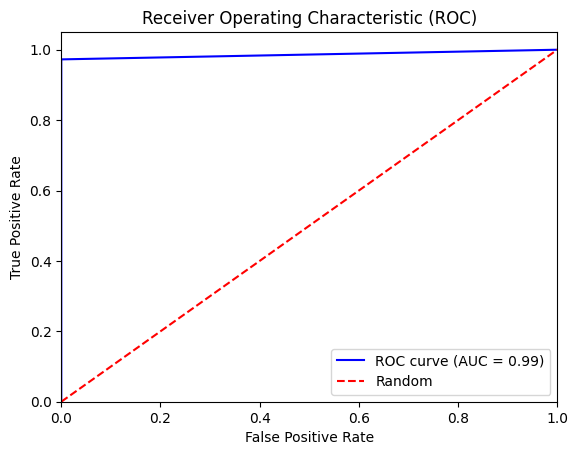

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, lgbm_predictions)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Creating a confusion matrice upsampled model.
print('Confusion Matrice - Upsampled model.')
print()
cm = confusion_matrix(target_test, lgbm_predictions)
print(cm)
print()
#Extracting TruePositive, FalsePositive, FalseNegative and TrueNegative from our confusion matrice.
tn, fn, fp, tp = confusion_matrix(target_test, lgbm_predictions).ravel()
print('True positive:', tp)
print('False positive:', fp)
print('False negative:', fn)
print('True negative:', tn)
print()
exact = tp + tn
wrong = fp + fn
print('Exact results=',exact)
print('Wrong results=',wrong)

Confusion Matrice - Upsampled model.

[[1287    0]
 [  13  461]]

True positive: 461
False positive: 13
False negative: 0
True negative: 1287

Exact results= 1748
Wrong results= 13


# Summary

In this project, I attempted to build a model using gradient boosting algorithms, specifically LightGBM and CatBoost. I performed target data balancing using the upsample method and applied one-hot encoding. After tuning the hyperparameters using GridSearchCV, it was found that LightGBM achieved a higher ROC-AUC score (0.986) compared to the CatBoost model, both with max_depth=5, learning_rate=0.1, and n_estimators=200.

The values indicated by the confusion matrix were also promising, with FP (False Positive) = 13 and FN (False Negative) = 0. This means that the model successfully avoided scenarios where it wrongly offered promo codes to customers who wouldn't actually leave, and it also didn't miss out on offering anything to customers who ended up leaving.

# Project Report

- During the exploratory data analysis process, I didn't encounter any significant challenges as the data used was relatively clean and had no missing values. However, I noticed discrepancies in the number of records between the Internet and Phone data compared to the number of clients and contracts. This required me to fill in the missing values in those columns.

- In the data preparation phase for training the model, I faced challenges in labeling the data. Initially, I used label encoding, but the model's performance didn't meet my expectations. After discussions, I decided to use the One Hot Encoding method, which yielded better performance than label encoding.

- For the model selection, I chose LightGBM and CatBoost based on the previous analysis. The LightGBM model produced slightly better ROC-AUC performance compared to the CatBoost model.

- Summary of model performance test results:
  - Accuracy Test: 0.993 || 0.991
  - ROC_AUC      : 0.986 || 0.984
  - F1_score     : 0.986 || 0.982

  Note: The values on the left side are for the LightGBM model, and the values on the right side are for the CatBoost model.